Marjum Pass, Oct 15-16 night. On the ground, ~70m baseline EW.

Inputs:

0: bicone + 2 amps + 90 MHz LPF

1: discone + 2 amps + 90 MHz LPF

2, 3: tentpole + FEM + PAM

4, 5: vivaldi + FEM + PAM

SNAP: C000091 (10.10.10.13)

In [7]:
from datetime import datetime
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from eigsep_corr import io
%matplotlib inline

In [14]:
DATA_DIR = "/home/christian/Documents/research/eigsep/eigsep_corr/eigsep_corr/data/data/night2/"
# subset of files with us definitely gone
files = sorted(glob(os.path.join(DATA_DIR, "20231015_2*")), key=os.path.getctime)
files += sorted(glob(os.path.join(DATA_DIR, "20231016_0*")), key=os.path.getctime)

In [16]:
h = io.read_file(files[0])[0]
PAIRS = h["pairs"]
N_ACC = len(h["acc_cnt"])
ACC_BINS = h["acc_bins"]
NCHAN = h["nchan"]
SAMPLE_RATE = h["sample_rate"]
FREQS = np.linspace(0, SAMPLE_RATE/2e6, NCHAN, endpoint=False)

In [17]:
autos = [p for p in PAIRS if len(p) == 1]
crosses = [p for p in PAIRS if len(p) == 2]
print(autos, crosses)
dauto = {}
dcross = {}

['0', '1', '2', '3', '4', '5'] ['02', '04', '24', '13', '15', '35']


In [20]:
files = files[100:200]

In [21]:
for pair in autos:
    d = np.empty((len(files), N_ACC, ACC_BINS, NCHAN))
    for i, f in enumerate(files):
        d[i] = io.read_file(f)[1][pair][..., 0]
    dauto[pair] = d

In [90]:
i = 34

35


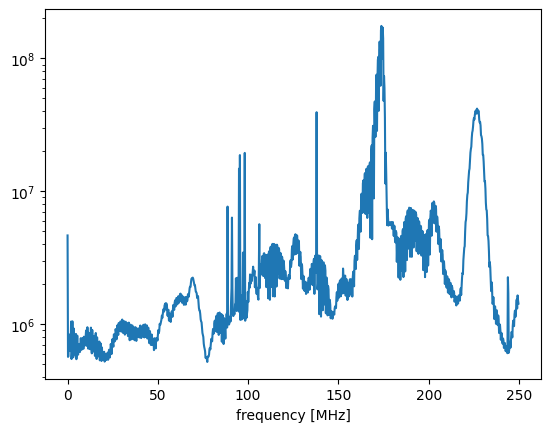

In [91]:
i+=1
print(i)
plt.figure()
plt.plot(FREQS, dauto["4"][i, 0, 0, :])
plt.yscale("log")
plt.xlabel("frequency [MHz]")
plt.savefig("fm_auto.png")
plt.show()

In [30]:
for pair in crosses:
    d = np.empty((len(files), N_ACC, ACC_BINS, NCHAN, 2))
    for i, f in enumerate(files):
        d[i] = io.read_file(f)[1][pair]
    dcross[pair] = d

In [50]:
dauto["4"].shape

(100, 60, 2, 1024)

In [49]:
dcross["24"].shape

(100, 60, 2, 1024, 2)

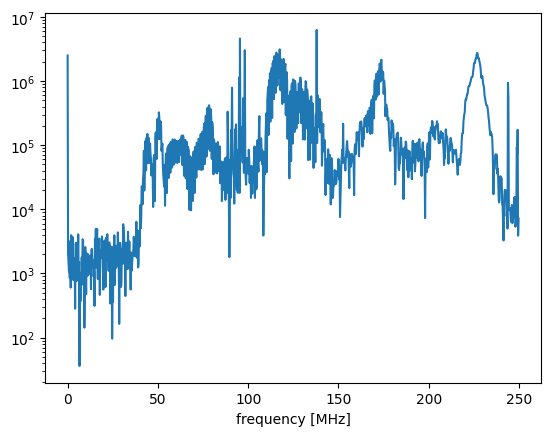

In [92]:
spec = dcross["24"][35, 0, 0, :, :]
abs = np.sqrt(spec[..., 0]**2 + spec[..., 1]**2)
plt.figure()
plt.plot(FREQS, abs)
plt.yscale("log")
plt.xlabel("frequency [MHz]")
plt.savefig("fm_cross.png")
plt.show()

In [16]:
dauto_stack = {}
for k, v in dauto.items():
    print(v.shape)
    dauto_stack[k] = v.mean(axis=(1, 2)).reshape(-1, NCHAN)

dcross_stack = {}
for k, v in dcross.items():
    dcross_stack[k] = v.mean(axis=(1, 2)).reshape(-1, NCHAN, 2)

(704, 60, 2, 1024)
(704, 60, 2, 1024)
(704, 60, 2, 1024)
(704, 60, 2, 1024)
(704, 60, 2, 1024)
(704, 60, 2, 1024)


In [17]:
np.savez_compressed("oct15_16.npz", dauto=dauto_stack, dcross=dcross_stack)

## Autos

In [3]:
data = np.load("oct15_16.npz", allow_pickle=True)
dauto_stack = data["dauto"][()]
dcross_stack = data["dcross"][()]

In [14]:
for k, v in dauto_stack.items():
    print(v.max(), v.min(), np.unravel_index(v.argmin(), shape=v.shape))

55173165.25 0.0 (0, 10)
47440206.28333333 0.0 (0, 12)
164795811.65 -610131225.3583333 (51, 638)
1148778974.3666666 -85172304.11666666 (395, 506)
399376051.90833336 -673282931.9583334 (51, 638)
261009444.61666667 -632469157.1833333 (47, 638)


In [41]:
FREQS[564]

137.6953125

/tmp/ipykernel_125750/2269913735.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(dauto_stack["3"]-np.min(np.abs(dauto_stack["3"]), axis=0))), **plot_kwargs)


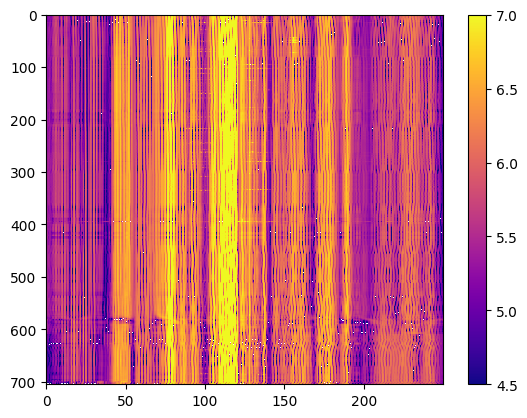

/tmp/ipykernel_125750/2269913735.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(dauto_stack["5"]-np.min(np.abs(dauto_stack["5"]), axis=0))), **plot_kwargs)


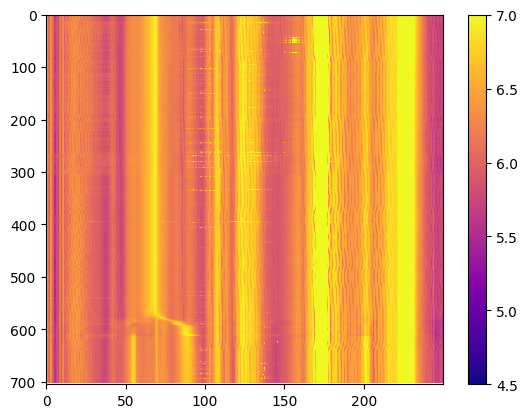

In [39]:
VMIN = 4.5
VMAX = 7
EXTENT = [FREQS[0], FREQS[-1], len(files), 0]
plot_kwargs = {"aspect": "auto", "extent": EXTENT, "vmin": VMIN, "vmax": VMAX, "interpolation": "none", "cmap": "plasma"}

plt.figure()
plt.imshow(np.log10(np.abs(dauto_stack["3"]-np.min(np.abs(dauto_stack["3"]), axis=0))), **plot_kwargs)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(np.abs(dauto_stack["5"]-np.min(np.abs(dauto_stack["5"]), axis=0))), **plot_kwargs)
plt.colorbar()
plt.show()

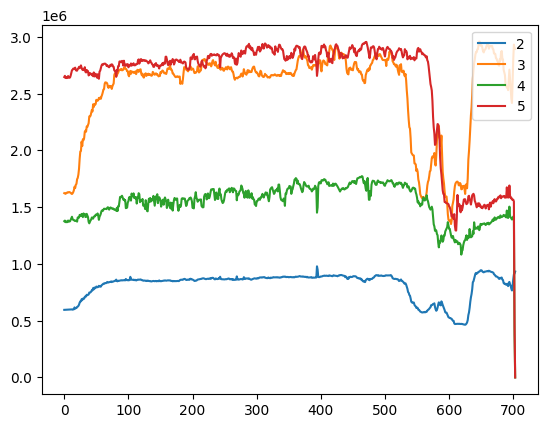

In [16]:
chan = 250
plt.figure()
for i in ["2", "3", "4", "5"]:
    plt.plot(dauto_stack[i][:, chan], label=i)
plt.legend(loc="upper right")
#plt.xlim(500, 700)plt.grid()
plt.show()

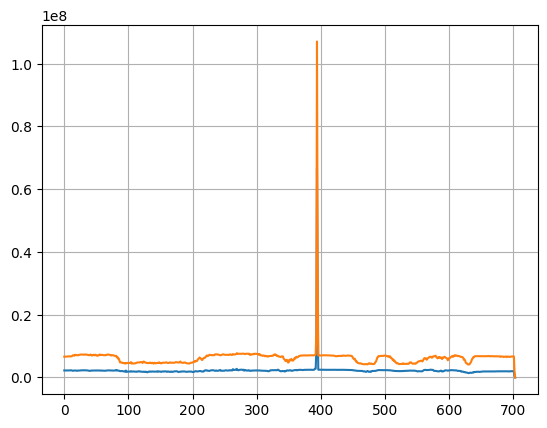

In [17]:
chan = 500
fig, axs = plt.subplots(nrows=1, sharex=True, sharey=True)
plt.sca(axs)
# plt.plot(dauto_stack["2"][:, chan])
# plt.plot(dauto_stack["3"][:, chan])
plt.plot(dauto_stack["4"][:, chan])
plt.plot(dauto_stack["5"][:, chan])
#plt.xlim(500, 700)
plt.grid()
plt.show()

## Cross

In [18]:
mag = {}
phase = {}
real = {}
imag = {}
for k, v in dcross_stack.items():
    re = v[..., 0]
    im = v[..., 0]
    real[k] = re
    imag[k] = im
    mag[k] = np.sqrt(re**2 + im**2)
    
    re -= re.mean(axis=0, keepdims=True)
    im -= im.mean(axis=0, keepdims=True)
    phase[k] = np.arctan2(im, re)

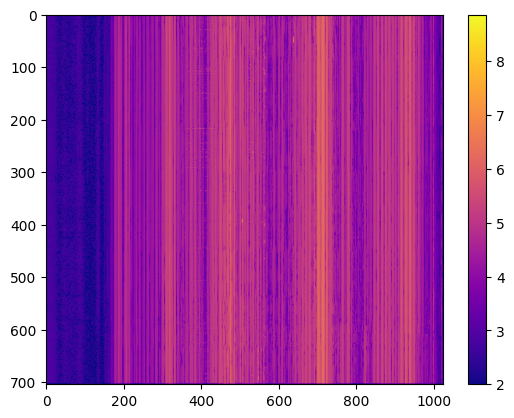

In [19]:
plt.figure()
plt.imshow(np.log10(mag["35"]), aspect="auto", cmap="plasma", vmin=2)
plt.colorbar()
plt.show()

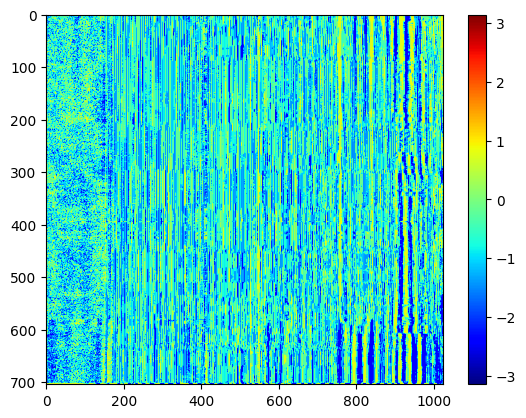

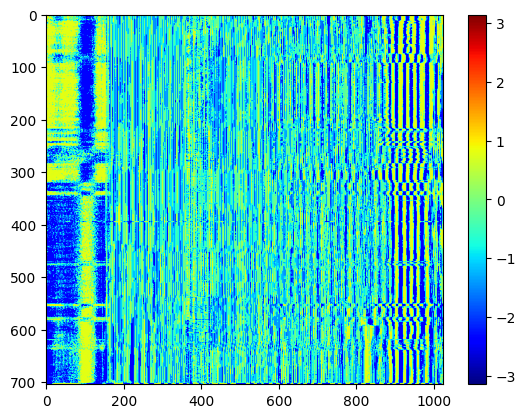

In [20]:
plt.figure()
plt.imshow(phase["35"], aspect="auto", cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(phase["24"], aspect="auto", cmap="jet", vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()

In [21]:
phase["35"].shape

(704, 1024)

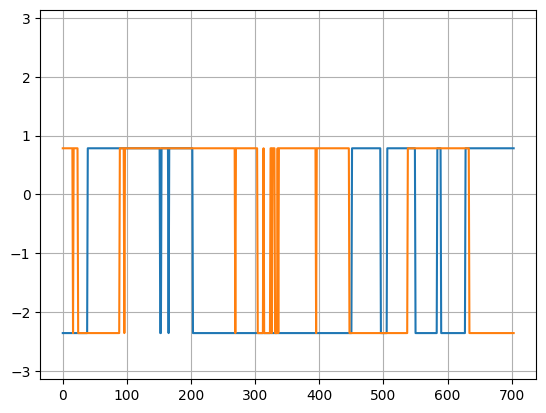

In [22]:
chan = 500
plt.figure()
plt.plot(phase["35"][:, chan], label="35")
plt.plot(phase["24"][:, chan], label="24")
plt.ylim(-np.pi, np.pi)
plt.grid()
plt.show()

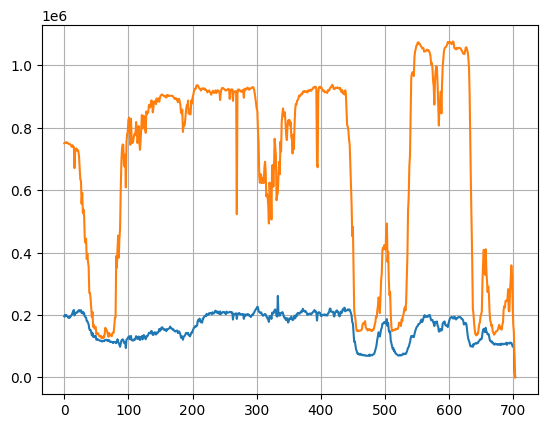

In [23]:
chan = 500
plt.figure()
plt.plot(mag["35"][:, chan], label="35")
plt.plot(mag["24"][:, chan], label="24")
#plt.ylim(-np.pi, np.pi)
plt.grid()
plt.show()

In [24]:
np.mean(imag["35"]**2)

1820564192222.5273

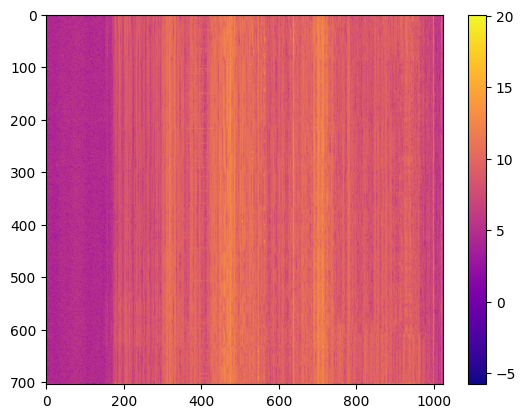

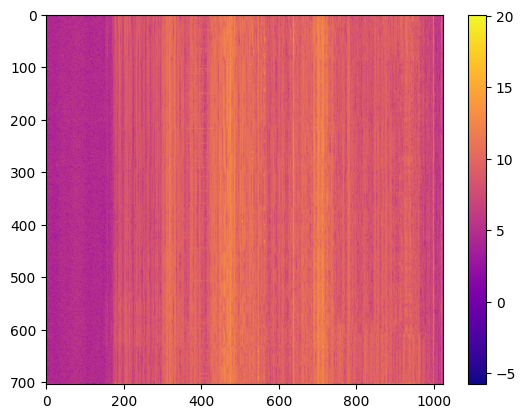

In [25]:
plt.figure()
plt.imshow(np.log(np.abs(real["35"])), aspect="auto", cmap="plasma")#, vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(np.abs(imag["35"])), aspect="auto", cmap="plasma")#, vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()

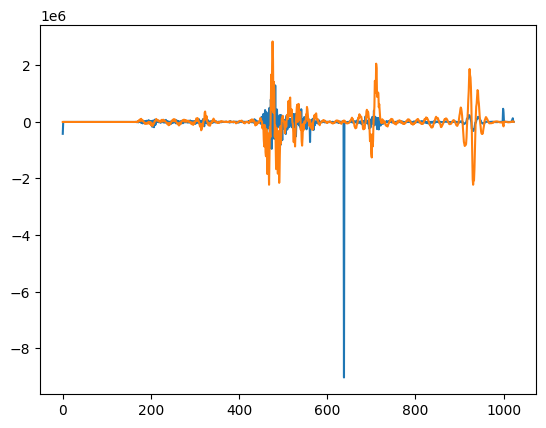

In [26]:
re1 = dcross_stack["24"][0, :, 0]
im1 = dcross_stack["24"][0, :, 1]
phase1 = np.arctan2(im1, re1)
re2 = dcross_stack["24"][250, :, 0]
im2 = dcross_stack["24"][250, :, 1]
phase2 = np.arctan2(im2, re2)
plt.figure()
plt.plot(re1)
plt.plot(im1)
#plt.xlim(200, 400)
plt.show()

In [27]:
dcross_stack["35"].shape

(704, 1024, 2)

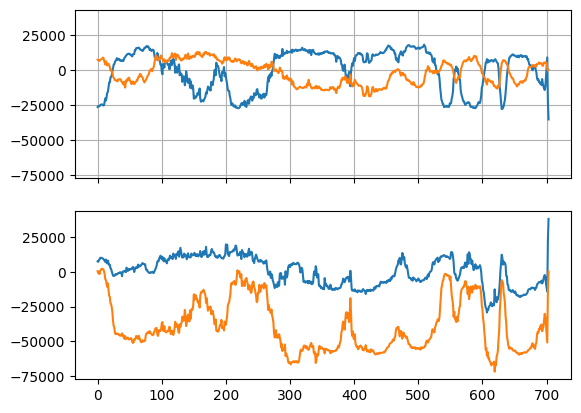

In [28]:
chan = 600
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
plt.sca(axs[0])
plt.plot(dcross_stack["35"][:, chan, 0])
plt.plot(dcross_stack["35"][:, chan, 1])
#plt.xlim(500, 700)
plt.grid()

plt.sca(axs[1])
plt.plot(dcross_stack["24"][:, chan, 0])
plt.plot(dcross_stack["24"][:, chan, 1])
plt.show()

In [29]:
files[60]

'/home/christian/Documents/research/eigsep/eigsep_corr/eigsep_corr/data/20231015_210455.eig'

In [30]:
h = io.read_file(files[0])[0]
datetime.fromtimestamp(h["times"][0])

datetime.datetime(2023, 10, 15, 19, 7, 12, 673439)

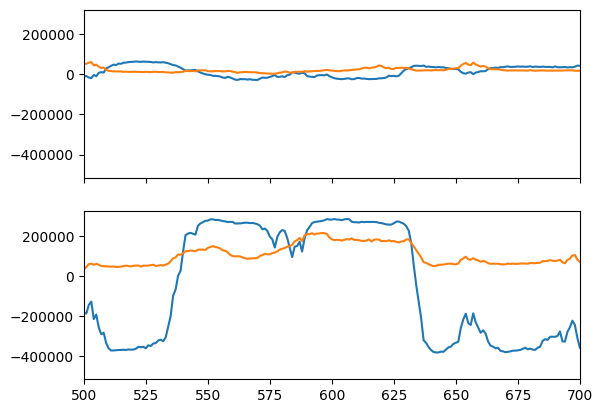

In [31]:
chan = 500
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
plt.sca(axs[0])
plt.plot(dcross_stack["35"][:, chan, 0])
plt.plot(dcross_stack["35"][:, chan, 1])
plt.xlim(500, 700)


plt.sca(axs[1])
plt.plot(dcross_stack["24"][:, chan, 0])
plt.plot(dcross_stack["24"][:, chan, 1])
plt.show()